# PyEddyTracker - Model Evaluation
## CONTENTS;
### 1. Load in data
Now, when I'm working from home, this notebook can only be used locally, however when I'm at uni I'll also be able to use this on gadi. 

For now though, we are writing this for a locally run notebook. That means that we need to find the relevant sea-level output from all datasets. 

In [1]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations

import xarray as xr
import glob
from netCDF4 import Dataset
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

In [2]:
# set paths to model output
adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'
## SRM
eac_003 = adt_datapath + 'eac_eta_1990-2000.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac_eta_sub.nc'
## PARENT
om2_01 = adt_datapath + 'om2_eta_1990-2020.nc' 

## AVISO
Load SSH Data (starting with AVISO)

In [3]:
adt_aviso = xr.open_dataset(adt_datapath + 'cmems-sealevel-adt.nc')
adt_aviso

<xarray.Dataset>
Dimensions:    (time: 10016, longitude: 86, latitude: 81)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-06-03
  * longitude  (longitude) float32 140.6 140.9 141.1 141.4 ... 161.4 161.6 161.9
  * latitude   (latitude) float32 -46.12 -45.88 -45.62 ... -26.62 -26.38 -26.12
Data variables:
    adt_cmems  (time, latitude, longitude) float64 ...

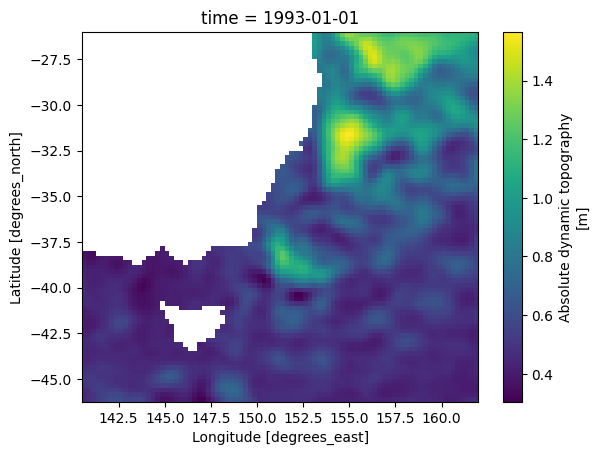

In [4]:
adt_aviso['adt_cmems'].isel(time=0).plot()

### Run ID algorithm (`eddy_identification`)

Okay, so the previous attempt failed because each individual map was the exact same. This stems from the fact that we set up this `RegularGridDataset` object with the full-time adt data rather than an individual snapshot. There's two options now:
1. Investigate whether some 'indexs' argument to `RegularGridDataset` could help
2. Select individual snapshots, re-save these and then try the slighly modified algorithm. 

So, I've now saved a years worth of individual dates using a bash script we've called `split-by-frame.sh`. Let's now loop through these, and save the eddy results that way...

# Track Eddies

In [5]:
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances

In [6]:
# Get files of eddy detection
ac_eddy_files = glob.glob(adt_datapath+'id-eddies_aviso-filtered/AC*.nc'); ac_eddy_files.sort()
cc_eddy_files = glob.glob(adt_datapath+'id-eddies_aviso-filtered/CC*.nc'); cc_eddy_files.sort()
print(len(ac_eddy_files), len(cc_eddy_files))


4461 4461


In [7]:
%%time
# compute eddy tracks
ac_correspondances = Correspondances(datasets=ac_eddy_files, virtual=3)
cc_correspondances = Correspondances(datasets=cc_eddy_files, virtual=3)
# track eddies
ac_correspondances.track(); cc_correspondances.track()
ac_correspondances.prepare_merging(); cc_correspondances.prepare_merging()
# merge results
ac_eddytracks = ac_correspondances.merge(raw_data=False)
cc_eddytracks = cc_correspondances.merge(raw_data=False)
# capture virtual eddies required
ac_eddytracks.virtual[:] = ac_eddytracks.time==0
cc_eddytracks.virtual[:] = cc_eddytracks.time==0
# interpolate between virtual eddy tracks
ac_eddytracks.filled_by_interpolation(ac_eddytracks.virtual == 1)
cc_eddytracks.filled_by_interpolation(cc_eddytracks.virtual == 1)

High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 5 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_co

CPU times: user 7min 12s, sys: 18.2 s, total: 7min 31s
Wall time: 14min 16s


In [9]:
4461/365

12.221917808219178

In [8]:
print(ac_eddytracks)

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 134524 observations from 15706 to 20166 (4461 days, ~30 obs/day)
    |   Speed area      : 0.30 Mkm²/day
    |   Effective area  : 0.42 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.72     18.49     14.18     10.51      7.32     21.58     27.20
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      5.88     34.44     26.83     14.81     11.72      6.32      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      5.35     25.85     20.74     15.47     17.65     14.89      0.05
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00 

In [10]:
print(cc_eddytracks)

    | 141774 observations from 15706 to 20166 (4461 days, ~32 obs/day)
    |   Speed area      : 0.25 Mkm²/day
    |   Effective area  : 0.35 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.84     20.63     15.23     10.93      7.38     21.49     23.51
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      7.14     41.30     26.65     12.81      8.62      3.49      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      6.44     29.96     23.52     16.23     14.96      8.89      0.01
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00 

Okay so now I've got these eddy tracks. Let's just work through a few of the examples to get a feel for how to play around with the data.

### Display Fields
Here we use `extract_with_length` to extract eddies with tracks of a particular length. 
* `extract_with_length`: Return the observations within trajectories lasting between [b0:b1]
   * **NOTE: This is length in "days" not in distance!**

In [64]:
# set day threshold to cutoff eddies below that
upper = 100
lower = 50
cc_subset = cc_eddytracks.extract_with_length((lower, upper)) # -1 means no upper limit

In [65]:
cc_subset.nb_tracks

551

Plot Amplitude field

In [113]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_xlim(adt_aviso.longitude.min().values, adt_aviso.longitude.max().values)
    ax.set_ylim(adt_aviso.latitude.min().values, adt_aviso.latitude.max().values)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.bottom_labels=False
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.04, 0.05, 0.9, 0.01]), orientation='horizontal')
    

In [114]:
def plot_subset_given_lengthbounds(dataset, upper, lower, polarity='Cold'):
    ds_sub = dataset.extract_with_length((lower, upper))
    ax = start_axes(f'{ds_sub.nb_tracks} {polarity} Core eddies lasting between {lower} and {upper} days')
    m = ds_sub.scatter(ax, 'age', ref=-10, s=1, transform=ccrs.PlateCarree())
    update_axes(ax, m)

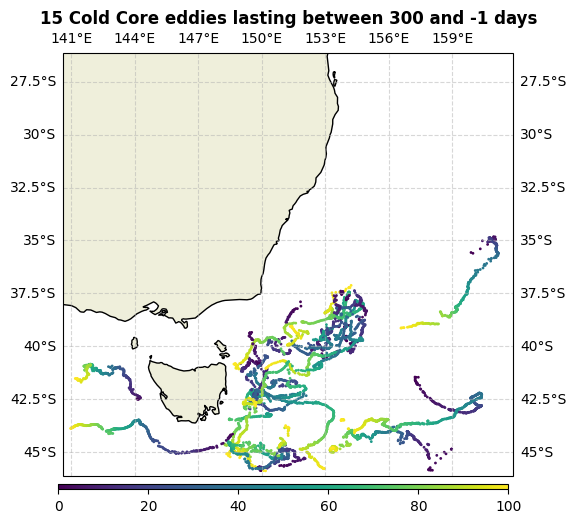

In [115]:
plot_subset_given_lengthbounds(dataset=cc_eddytracks, lower=300, upper=-1, polarity='Cold')

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


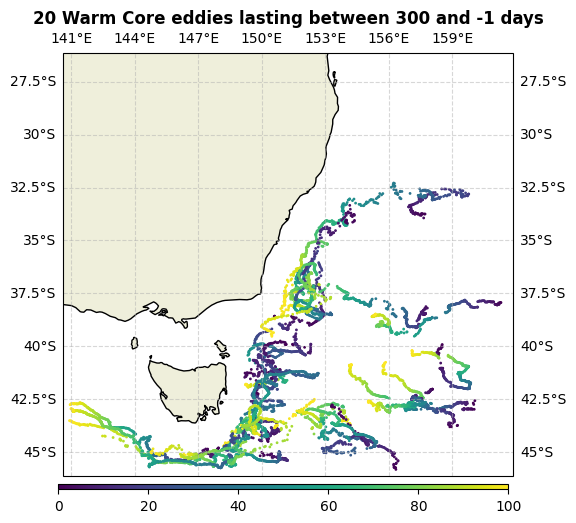

In [110]:
plot_subset_given_lengthbounds(dataset=ac_eddytracks, lower=300, upper=-1, polarity='Warm')

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please 

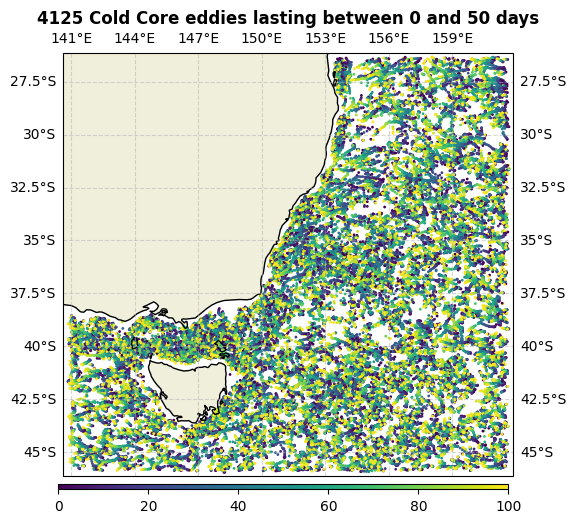

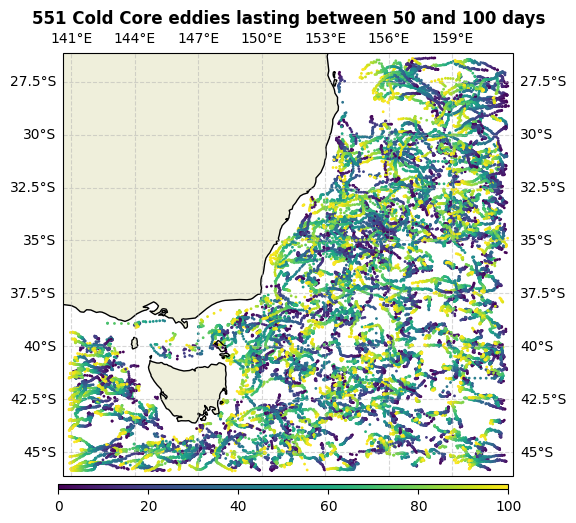

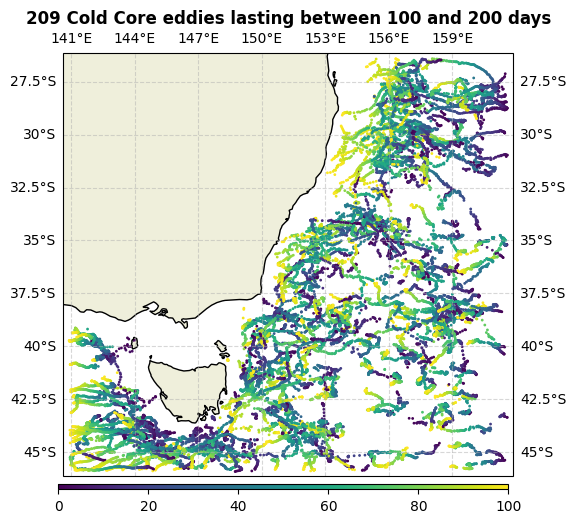

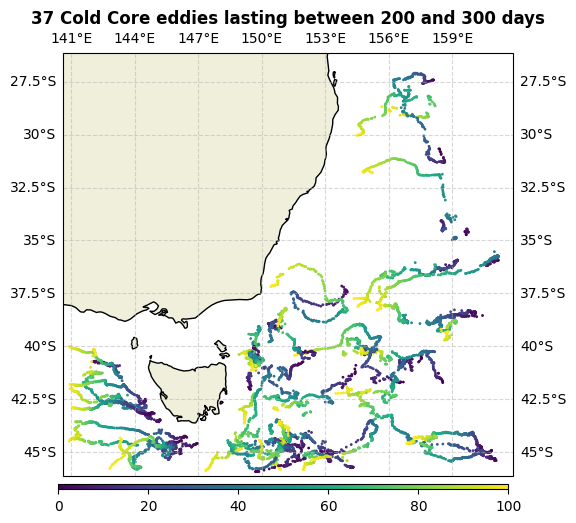

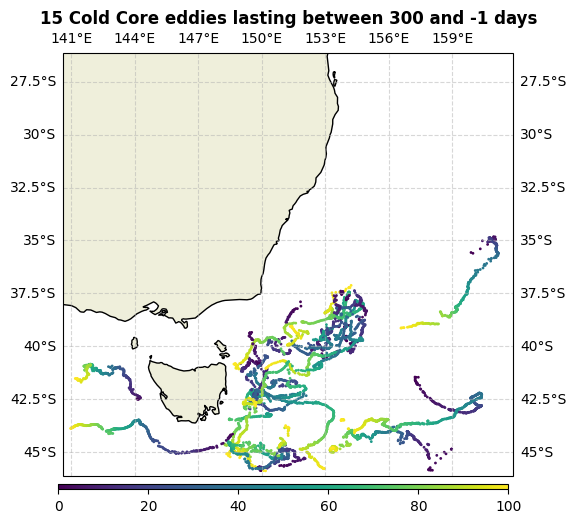

In [111]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

for bounds in zip(lower, upper):
    plot_subset_given_lengthbounds(dataset=cc_eddytracks, lower=bounds[0], upper=bounds[1], polarity='Cold')

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please 

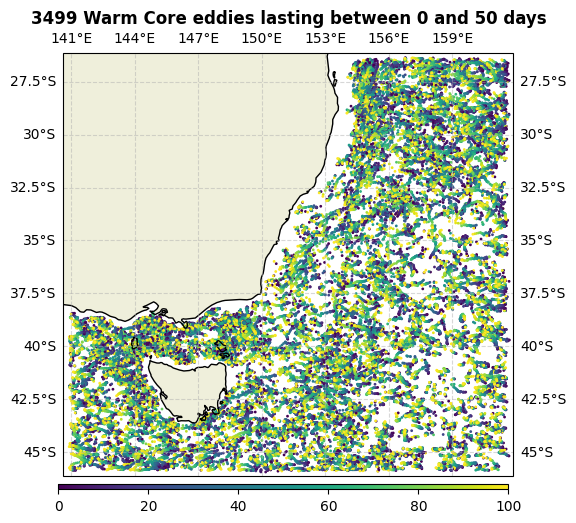

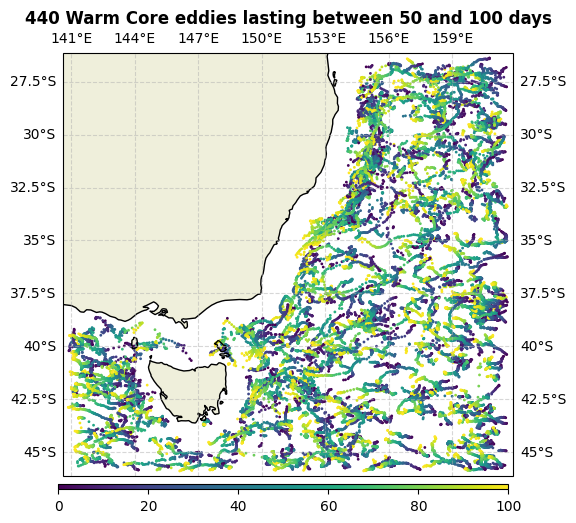

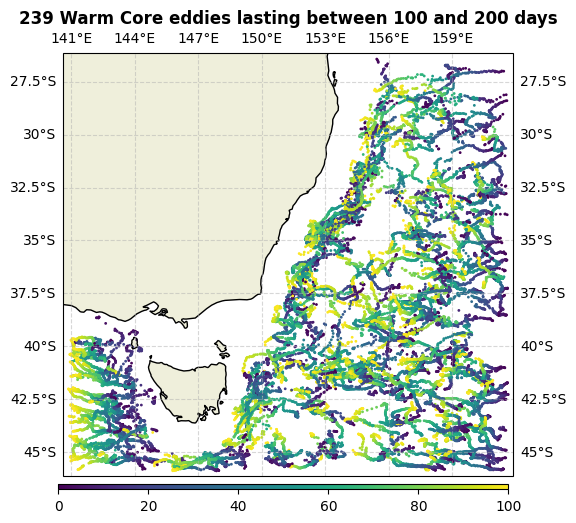

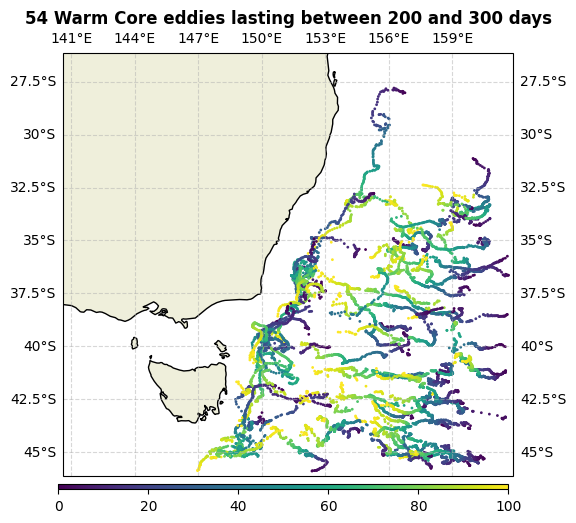

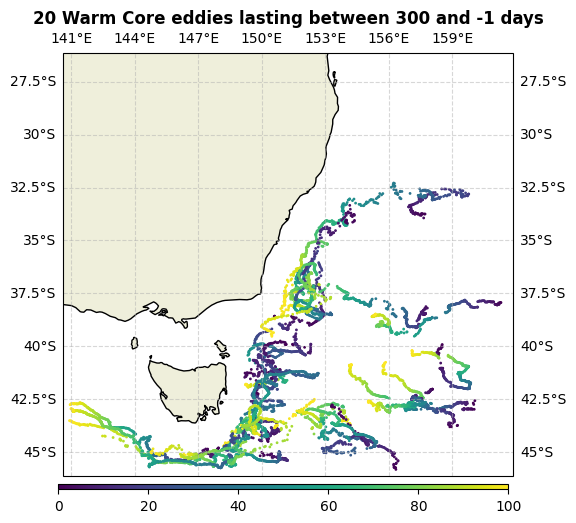

In [112]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

for bounds in zip(lower, upper):
    plot_subset_given_lengthbounds(dataset=ac_eddytracks, lower=bounds[0], upper=bounds[1], polarity='Warm')

### Tracks which go through area
Here we use another new method called `position_filter`. This seems to a filter based on the `loess` algorithm, standing for "locally estimated scatterplot smoothing" - chatGPT refers to this as a *"weighted scatterplot smoothing algorithm. It's a non-parameteric method used for smoothing noisy data by fitting a low-degree polynomial to localised subsets of the data"*. 

In [119]:
cc_filt = cc_eddytracks.copy()
ac_filt = ac_eddytracks.copy()
cc_filt = cc_filt.extract_with_length((100,-1))
ac_filt = ac_filt.extract_with_length((100,-1))

cc_filt.position_filter(median_half_window=1, loess_half_window=5)
ac_filt.position_filter(median_half_window=1, loess_half_window=5)

We extract eddies in the area set below, but we ask to keep `full_path`

In [125]:
x0, x1, y0, y1 = 155-1, 158-1, -35, -32
area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
cc_withinbox = cc_filt.extract_with_area(area, full_path=True)
ac_withinbox = ac_filt.extract_with_area(area, full_path=True)

#### Plot

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


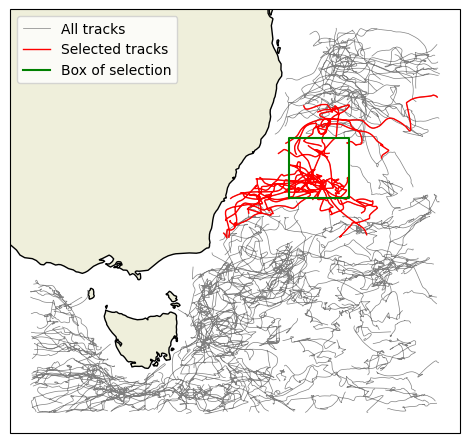

In [126]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
cc_filt.plot(ax, color='grey', lw=0.5, ref=-10, label="All tracks", transform=ccrs.PlateCarree())
cc_withinbox.plot(
    ax, color='r', lw=1, ref=-10, label='Selected tracks', transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.grid()
ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color='g',
    lw=1.5,
    label='Box of selection'
)
ax.legend()

This again is a pretty cool feature and will come in handy and look more interesting when combined with the 'extract_with_length' method as well as longer timeseries.

### One Track
Using the `extract_longer_eddies` method, we determine a threshold whereby 

In [60]:
eddy = ac_eddytracks.extract_with_length((100,-1))
eddy

| 600 observations from 15706 to 15805 (100 days, ~6 obs/day)
    |   Speed area      : 0.09 Mkm²/day
    |   Effective area  : 0.13 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      1.50      4.33     11.17      2.33     21.17     59.50
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      7.83     39.17     17.00     18.00     17.83      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      2.17      5.33     18.00     43.33     31.00      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     70.77       nan       nan       nan
        Mean effective radius (km):        nan     88.50       nan       nan       nan
        Mean amplitude (cm)       :        nan     11.69       nan       nan       nan
    | 6 tracks (100.00 obs/tracks, shorter 100 obs, longer 100 obs)
    |   4 filled observations (0.67 obs/tracks, 0.67 % of total)
    |   Intepolated speed area      : 0.00 Mkm²/day
    |   Intepolated effective area  : 0.00 Mkm²/day
    |   Distance by day             : Mean 2.47 , Median 2.23 km/day
    |   Distance by track           : Mean 254.64 , Median 235.41 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00
    |   Percent of eddies         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00

In [65]:
# filter
eddy.position_filter(median_half_window=1, loess_half_window=5)

In [81]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
    

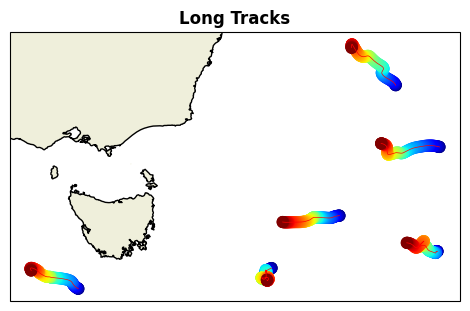

In [82]:
# Plot
ax = start_axes('Long Tracks')
eddy.plot(ax, color='r', lw=0.5)
eddy.scatter(ax, 'n', cmap='jet', s=60)
update_axes(ax)

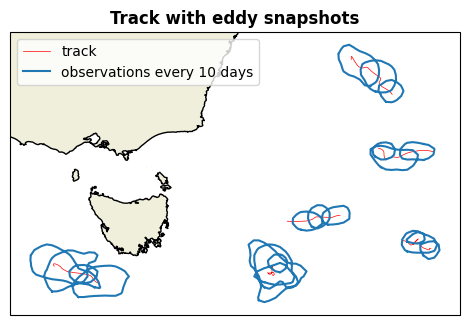

In [85]:
# Plot track with shape snapshots
ax = start_axes('Track with eddy snapshots')
eddy.plot(ax, color='r', lw=0.5, label='track')
eddy.index(range(0, len(eddy), 30)).display(
    ax, intern_only=True, label="observations every 10 days")
ax.legend()

That index method is a good trick - select only particular timesteps of an eddies track

### Display Tracks

In [87]:
# keep eddies longer than 20 weeks
ac_long = ac_eddytracks.extract_with_length((7*10, -1))
cc_long = cc_eddytracks.extract_with_length((7*10, -1))
print(ac_long)
print(cc_long)

    | 942 observations from 15706 to 15805 (100 days, ~9 obs/day)
    |   Speed area      : 0.13 Mkm²/day
    |   Effective area  : 0.20 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      5.52     14.44     13.91      2.87     16.35     46.92
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.53     13.69     35.56     17.09     17.41     15.71      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.42      5.31     14.65     20.17     31.21     28.24      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -1

Position filter for nicer display

In [88]:
ac_long.position_filter(median_half_window=1, loess_half_window=5)
cc_long.position_filter(median_half_window=1, loess_half_window=5)

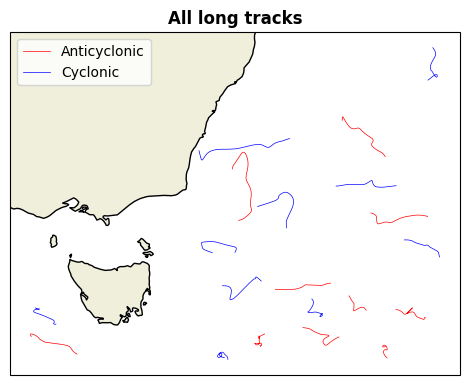

In [89]:
# Plot
ax = start_axes('All long tracks')
ac_long.plot(ax, ref=-10, label="Anticyclonic", color='r', lw=0.5)
cc_long.plot(ax, ref=-10, label="Cyclonic", color='b', lw=0.5)
ax.legend()
ax.grid()

## Tracking Diagnostics
### Geographical Statistics

In [ ]:
# Merge ac and cc
eddies_merged = ac_eddytracks.merge(cc_eddytracks)
step = 0.1

Mean of amplitude in each box

In [104]:
coord_bounds = {'W':adt_aviso.longitude.min().values, 'E':adt_aviso.longitude.max().values,
                'S':adt_aviso.latitude.min().values, 'N':adt_aviso.latitude.max().values}

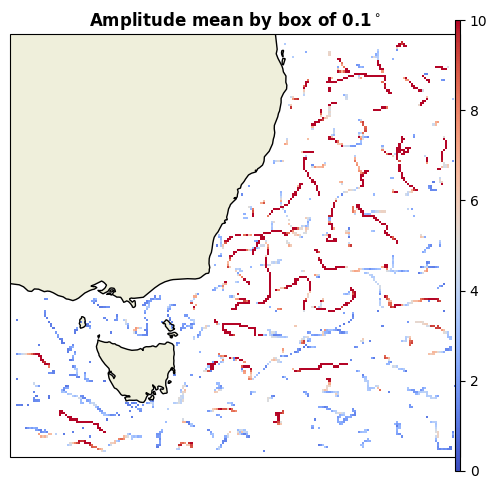

In [107]:
ax = start_axes("Amplitude mean by box of %s$^\circ$" % step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step), 
                            (coord_bounds['S'], coord_bounds['N'], step)), 
                            varname='amplitude')
m = g.display(ax, name='amplitude', vmin=0, vmax=10, factor=100)
ax.grid()
update_axes(ax, m)

Okay, so once we have a lot of data, these ***Eulerian*** methods of visualising and diagnosing the eddy metrics will be really useful and interesting. We can then compare these maps between datasets.

Mean of speed radius in each box